In [1]:
#%matplotlib notebook
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from skimage.transform import resize, radon
sys.path.append("../src")
from digits import *
from ect import *

In [2]:
X, Y = get_digits("Digits")
XTest, YTest = get_digits("DigitsTest")

# ECT Example

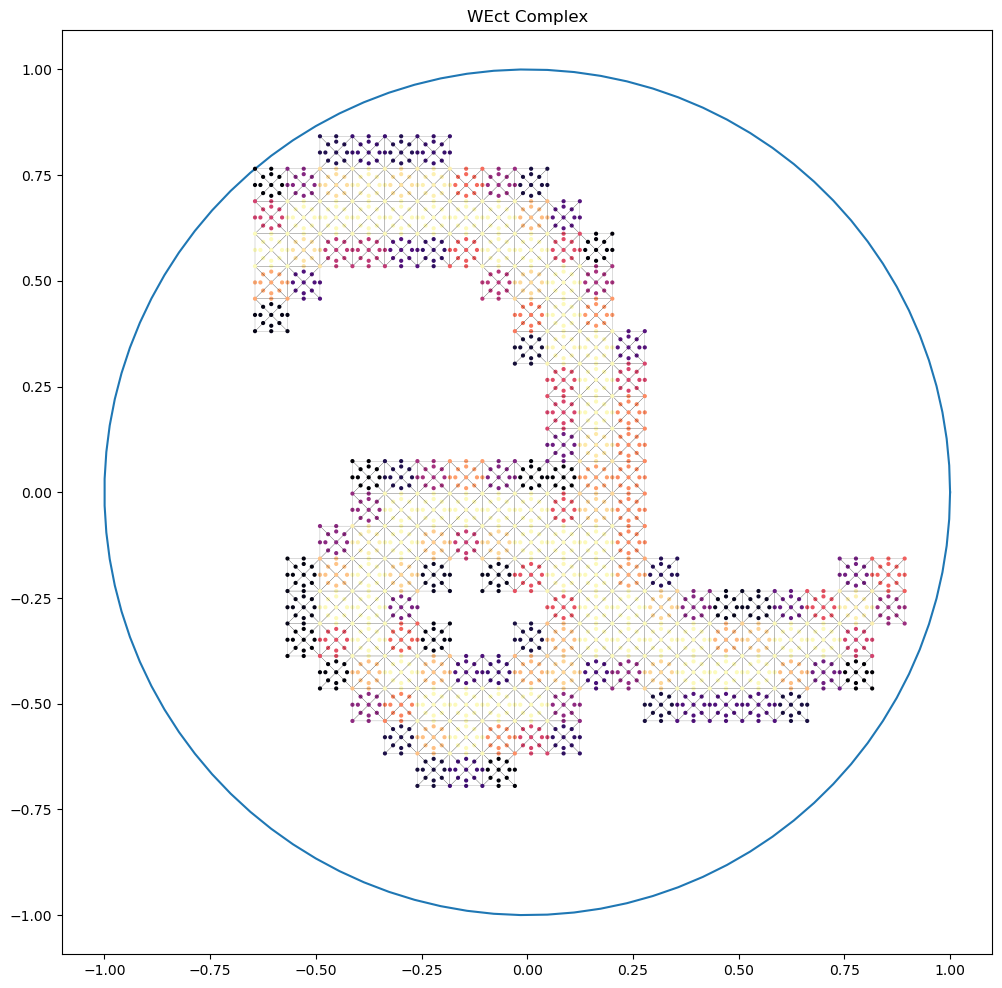

In [3]:
img = np.round(np.reshape(X[14004], (28, 28))*255)
wect_complex = get_wect_complex_img2d(img)

v = wect_complex["vertices"]["v"]
Vw = wect_complex["vertices"]["Vw"]
tidxs = wect_complex["tris"]["idxs"]
t1 = v[tidxs[:, 0], :]
t2 = v[tidxs[:, 1], :]
t3 = v[tidxs[:, 2], :]
Fw = wect_complex["tris"]["Fw"]
eidxs = wect_complex["edges"]["idxs"]
e1 = v[eidxs[:, 0], :]
e2 = v[eidxs[:, 1], :]
Ew = wect_complex["edges"]["Ew"]


## Check Results
plt.figure(figsize=(12, 12))
plt.scatter(v[:, 0], v[:, 1], s=4, c=Vw, zorder=100, vmin=0, vmax=255, cmap='magma')
ctri = []
for [x1, y1], [x2, y2], [x3, y3], w in zip(t1, t2, t3, Fw):
    plt.plot([x1, x2, x3, x1], [y1, y2, y3, y1], c='k', linewidth=0.1)
    ctri.append([(x1+x2+x3)/3, (y1+y2+y3)/3])
ctri = np.array(ctri)
plt.scatter(ctri[:, 0], ctri[:, 1], c=Fw, s=4, vmin=0, vmax=255, cmap='magma')
e = 0.5*(e1 + e2)
plt.scatter(e[:, 0], e[:, 1], s=4, c=Ew, vmin=0, vmax=255, cmap='magma')
t = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(t), np.sin(t))
plt.axis("equal")
plt.title("WEct Complex")
plt.savefig("WEctComplex.svg", bbox_inches='tight')

Wect 0.0005609989166259766
Curve 0.02744293212890625
Resize 0.0004980564117431641


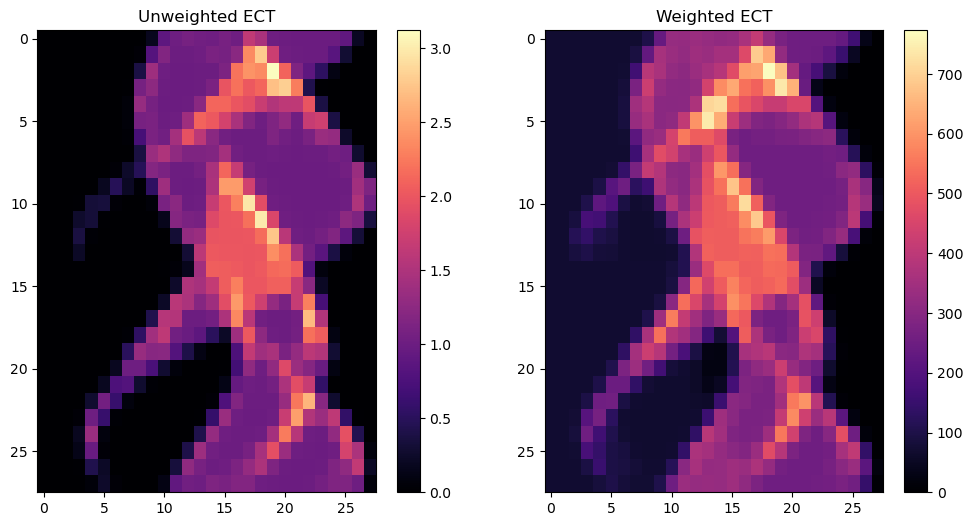

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
tic = time.time()
wect_complex = get_wect_complex_img2d(img)
print("Wect", time.time()-tic)
tic = time.time()
t, ds, chi = get_curve(wect_complex, 100, 100, False)
print("Curve", time.time()-tic)
tic = time.time()
chi = resize(chi, (28, 28), anti_aliasing=True)
print("Resize", time.time()-tic)
plt.imshow(chi, aspect='auto', cmap='magma')
plt.title("Unweighted ECT")
plt.colorbar()
plt.subplot(122)
t, ds, chi = get_curve(wect_complex, 100, 100, True)
chi = resize(chi, (28, 28), anti_aliasing=True)
plt.imshow(chi, aspect='auto', cmap='magma')
plt.title("Weighted ECT")
plt.colorbar()
plt.savefig("WEct.png", bbox_inches='tight')

# Classifications

In [5]:
def evaluate_models(XAll, YAll, cv=10):
    from sklearn import svm
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import cross_val_score
    result = cross_val_score(KNeighborsClassifier(n_neighbors=7), XAll, YAll, cv=cv)
    print("KNN", np.mean(result), np.std(result))
    result = cross_val_score(LogisticRegression(penalty='l2'), XAll, YAll, cv=cv)
    print("Logistic", np.mean(result), np.std(result))
    result = cross_val_score(svm.SVC(kernel='linear'), XAll, YAll, cv=cv)
    print("SVM", np.mean(result), np.std(result))

## Euclidean Classifications

In [6]:
evaluate_models(np.concatenate((X, XTest), axis=0), 
                np.concatenate((Y, YTest)))

KNN 0.9705 0.002659791306835641


/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic 0.9227714285714285 0.005715785517462389
SVM 0.9370285714285715 0.005689517751523225


## ECT Classifications

In [7]:
def get_ect(XOrig, orig_res, final_res, weighted):
    imgres = int(XOrig.shape[1]**0.5) # Assuming square image
    XEct = []
    for i in range(XOrig.shape[0]):
        if i%1000 == 0:
            print(".", end="")
        x = np.reshape(XOrig[i, :], (imgres, imgres))
        wect_complex = get_wect_complex_img2d(x)
        _, _, chi = get_curve(wect_complex, orig_res, orig_res, weighted)
        if final_res < orig_res:
            chi = resize(chi, (final_res, final_res), anti_aliasing=True)
        XEct.append(chi.flatten())
    return np.array(XEct)

print("Getting ECT on training data...")
XEct = get_ect(X, 100, 28, False)
print("Getting ECT on test data...")
XTestEct = get_ect(XTest, 100, 28, False)

print("Getting weighted ECT on training data...")
XWEct = get_ect(X, 100, 28, True)
print("Getting weighted ECT on test data...")
XTestWEct = get_ect(XTest, 100, 28, True)

Getting ECT on training data...
............................................................Getting ECT on test data...
..........Getting weighted ECT on training data...
............................................................Getting weighted ECT on test data...
..........

In [8]:
print("ECT")
evaluate_models(np.concatenate((XEct, XTestEct), axis=0), 
                np.concatenate((Y, YTest)))

ECT
KNN 0.9614142857142858 0.0026607118887812895


/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic 0.9597142857142856 0.0033654911398256493
SVM 0.9619 0.0020444549196221994


In [9]:
print("WECT")
evaluate_models(np.concatenate((XWEct, XTestWEct), axis=0), 
                np.concatenate((Y, YTest)))

WECT
KNN 0.9733142857142857 0.002681607802823368


/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic 0.9695714285714285 0.002762725657973387
SVM 0.9763142857142857 0.0018236541025409088


## Radon Classifications

In [10]:
def get_radons(XOrig, res):
    XRadon = []
    for i in range(XOrig.shape[0]):
        if i%1000 == 0:
            print(".", end="")
        x = np.reshape(XOrig[i, :], (res, res))
        r = radon(x, theta=np.linspace(0, 180, res+1)[0:res])
        XRadon.append(r.flatten())
    return np.array(XRadon)

print("Getting radons on training data...")
XRadon = get_radons(X, 28)
print("Getting radons on test data...")
XTestRadon = get_radons(XTest, 28)

Getting radons on training data...
.

/home/ctralie/anaconda3/lib/python3.11/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


...........................................................Getting radons on test data...
..........

In [11]:
evaluate_models(np.concatenate((XRadon, XTestRadon), axis=0), 
                np.concatenate((Y, YTest)))

KNN 0.9710285714285714 0.002405605698261923


/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/ctralie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

Logistic 0.9184285714285714 0.0061740073977068315
SVM 0.9305571428571427 0.004979324599721096
